Using device: cuda


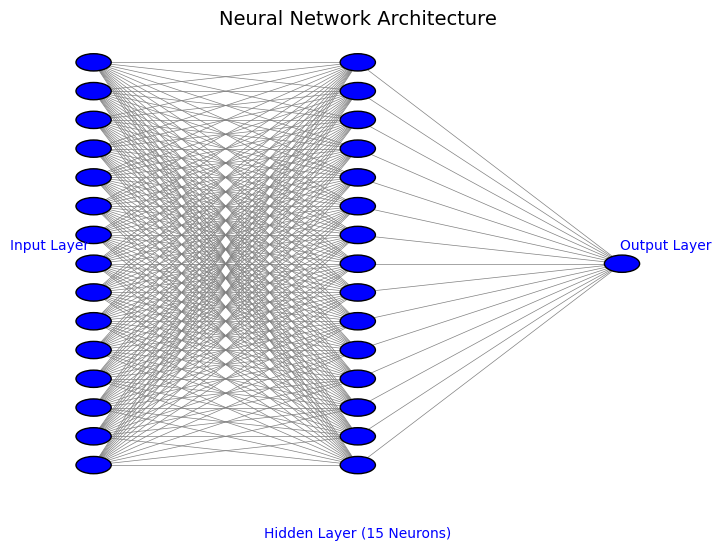

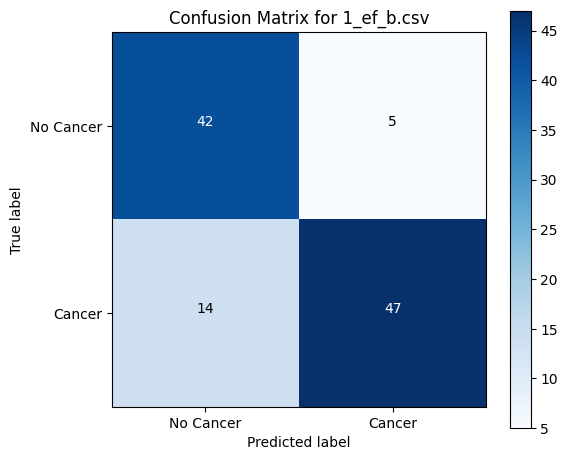

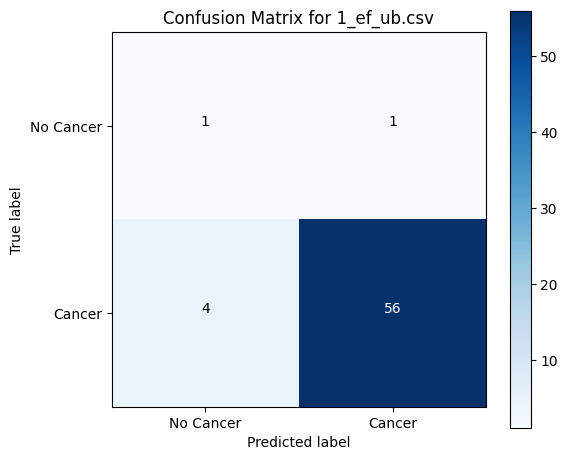

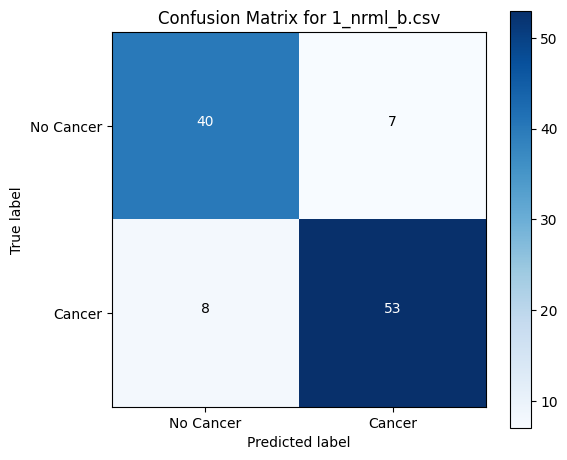

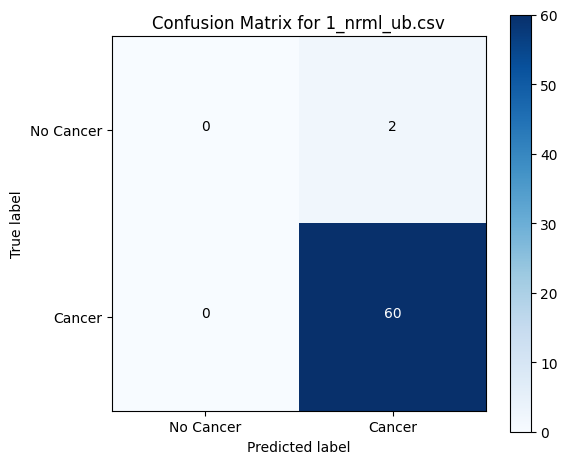

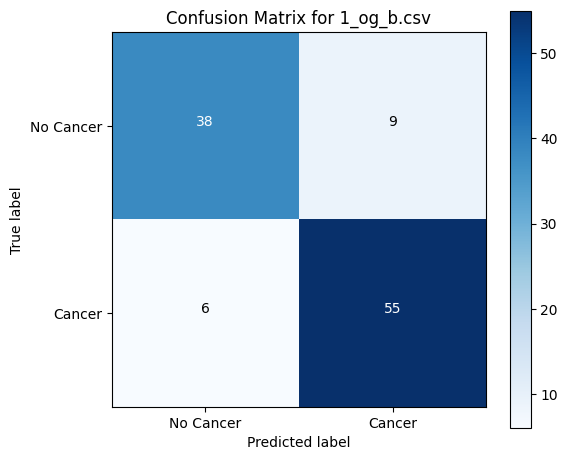

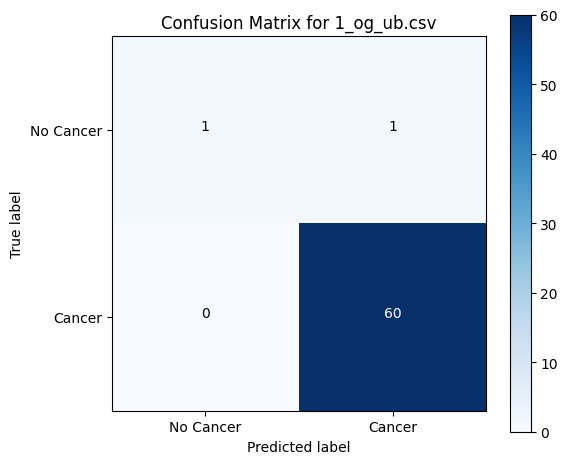

         Dataset  Accuracy  Precision    Recall  F1 Score
0     1_ef_b.csv  0.824074   0.903846  0.770492  0.831858
1    1_ef_ub.csv  0.919355   0.982456  0.933333  0.957265
2   1_nrml_b.csv  0.861111   0.883333  0.868852  0.876033
3  1_nrml_ub.csv  0.967742   0.967742  1.000000  0.983607
4     1_og_b.csv  0.861111   0.859375  0.901639  0.880000
5    1_og_ub.csv  0.983871   0.983607  1.000000  0.991736


In [47]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# List of dataset file paths
dataset_paths = [
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_ef_b.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_ef_ub.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_nrml_b.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_nrml_ub.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_og_b.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_og_ub.csv'
]

# Function to load and preprocess data without validation split
def load_and_preprocess_data(file_path, test_size=0.2):
    df = pd.read_csv(file_path)
    X = df.drop(columns=['LUNG_CANCER']).values
    y = df['LUNG_CANCER'].values
    
    # Check if labels are 1 and 2, and map to 0 and 1 if needed
    if set(np.unique(y)) == {1, 2}:
        y = np.where(y == 1, 0, 1)
    
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)
    
    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor

# Define a simple MLP with a fixed structure
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super(SimpleMLP, self).__init__()
        # Create hidden layer
        self.fc1 = nn.Linear(input_dim, hidden_layers[0])
        # Output layer
        self.fc2 = nn.Linear(hidden_layers[0], 1)
        self.activation = nn.ReLU()
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.output_activation(self.fc2(x))
        return x

# Visualize network architecture
def visualize_network(input_dim, hidden_layers):
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    ax.set_title("Neural Network Architecture", fontsize=14)
    ax.axis('off')
    
    # Define the layer structure
    layers = [(input_dim, 0)] + [(hidden_layers[0], 1), (1, 2)]
    
    max_nodes = max(input_dim, *hidden_layers, 1)
    spacing_y = 10 / max_nodes
    spacing_x = 3

    # Plot each layer
    for i, (n_nodes, x_pos) in enumerate(layers):
        for j in range(n_nodes):
            y_pos = j * spacing_y - (n_nodes / 2) * spacing_y
            circle = plt.Circle((x_pos * spacing_x, y_pos), radius=0.2, color='b', ec='k', zorder=2)
            ax.add_patch(circle)

            # Draw connections to the next layer
            if i < len(layers) - 1:
                next_n_nodes = layers[i + 1][0]
                next_x_pos = layers[i + 1][1] * spacing_x
                for k in range(next_n_nodes):
                    next_y_pos = k * spacing_y - (next_n_nodes / 2) * spacing_y
                    plt.plot([x_pos * spacing_x, next_x_pos], [y_pos, next_y_pos], color='gray', linewidth=0.5, zorder=1)

    plt.text(0 * spacing_x - 0.5, 0, "Input Layer", ha='center', fontsize=10, color='blue')
    plt.text(1 * spacing_x, -max_nodes * spacing_y / 1.5, "Hidden Layer (15 Neurons)", ha='center', fontsize=10, color='blue')
    plt.text(2 * spacing_x + 0.5, 0, "Output Layer", ha='center', fontsize=10, color='blue')
    plt.show()

# Display the architecture of the network
input_dim = 15  # Adjust this as needed for your dataset's feature count
hidden_layers = [15]
visualize_network(input_dim, hidden_layers)

# Function to train the model
def train_model(model, criterion, optimizer, X_train, y_train, n_epochs=100):
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        train_loss = criterion(y_pred, y_train)
        train_loss.backward()
        optimizer.step()

# Function to evaluate the model and return metrics and confusion matrix
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).cpu().numpy()
    y_pred_class = (y_pred > 0.5).astype(int)
    y_test_np = y_test.cpu().numpy()
    
    accuracy = accuracy_score(y_test_np, y_pred_class)
    precision = precision_score(y_test_np, y_pred_class, zero_division=0)
    recall = recall_score(y_test_np, y_pred_class, zero_division=0)
    f1 = f1_score(y_test_np, y_pred_class, zero_division=0)
    conf_matrix = confusion_matrix(y_test_np, y_pred_class)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'conf_matrix': conf_matrix
    }

# Function to plot confusion matrix using matplotlib
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Cancer', 'Cancer'])
    plt.yticks(tick_marks, ['No Cancer', 'Cancer'])

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Run training and evaluation on each dataset
results = []
for dataset_path in dataset_paths:
    # Load and preprocess data
    X_train, X_test, y_train, y_test = load_and_preprocess_data(dataset_path)
    input_dim = X_train.shape[1]
    
    # Initialize model, loss, and optimizer
    model = SimpleMLP(input_dim, hidden_layers=[15]).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    train_model(model, criterion, optimizer, X_train, y_train, n_epochs=100)
    
    # Evaluate model
    eval_metrics = evaluate_model(model, X_test, y_test)
    
    # Store results
    results.append({
        'dataset': dataset_path,
        'metrics': eval_metrics
    })

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    dataset_name = os.path.basename(dataset_path)
    plot_confusion_matrix(eval_metrics['conf_matrix'], title=f'Confusion Matrix for {dataset_name}')
    plt.show()

# Collect results in a DataFrame for easy comparison
metrics_summary = pd.DataFrame([
    {
        'Dataset': os.path.basename(result['dataset']),  # Use only the file name
        'Accuracy': result['metrics']['accuracy'],
        'Precision': result['metrics']['precision'],
        'Recall': result['metrics']['recall'],
        'F1 Score': result['metrics']['f1_score']
    }
    for result in results
])

# Display the metrics summary
print(metrics_summary)


Using device: cuda
Testing config 1/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=adam, Epochs=10
Average F1-Score: 0.7151471377711118

Testing config 2/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=adam, Epochs=25
Average F1-Score: 0.44468758294845256

Testing config 3/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=adam, Epochs=50
Average F1-Score: 0.7573352475613232

Testing config 4/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=sgd, Epochs=10
Average F1-Score: 0.3392157330132663

Testing config 5/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=sgd, Epochs=25
Average F1-Score: 0.36785074731647044

Testing config 6/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=sgd, Epochs=50
Average F1-Score: 0.4416055893833833

Testing config 7/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=rmsprop, Epoch

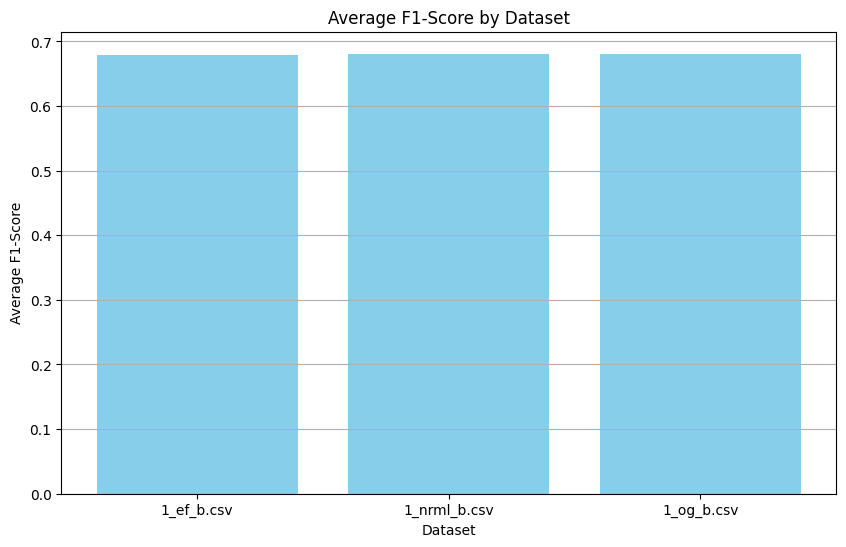

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Function to load and preprocess data
def load_and_preprocess_data(file_path, test_size=0.2):
    df = pd.read_csv(file_path)
    X = df.drop(columns=['LUNG_CANCER']).values
    y = df['LUNG_CANCER'].values

    # Check if labels are 1 and 2, and map to 0 and 1 if needed
    if set(np.unique(y)) == {1, 2}:
        y = np.where(y == 1, 0, 1)

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42)

    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor

# Define a configurable MLP architecture with PyTorch
class ConfigurableMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation):
        super(ConfigurableMLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for neurons in hidden_layers:
            layers.append(nn.Linear(prev_dim, neurons))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            prev_dim = neurons
        layers.append(nn.Linear(prev_dim, 1))  # Output layer
        layers.append(nn.Sigmoid())  # Binary classification
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            verbose (bool): If True, prints a message for each improvement.
            delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

# List of dataset paths to evaluate
dataset_paths = [
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_ef_b.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_nrml_b.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_og_b.csv'
]

# Define hyperparameter grid including 'dataset_path'
param_grid = {
    'dataset_path': dataset_paths,  # Added dataset paths
    'hidden_layers': [
        [15], [15, 15], [15, 15, 15], [15, 15, 15, 15], [15, 15, 15, 15, 15]
    ],
    'learning_rate': [0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'epochs': [10, 25, 50],  # Updated epoch options
}

# Fixed parameters
batch_size = 32  # Not used in current implementation but kept for reference

# Perform grid search
results = []
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Calculate total number of configurations for progress tracking
total_configs = len(param_grid['dataset_path']) * len(param_grid['hidden_layers']) * len(param_grid['learning_rate']) * \
               len(param_grid['activation']) * len(param_grid['optimizer']) * len(param_grid['epochs'])
current_config = 1

for dataset_path in param_grid['dataset_path']:
    for hidden_layers in param_grid['hidden_layers']:
        for learning_rate in param_grid['learning_rate']:
            for activation in param_grid['activation']:
                for optimizer_name in param_grid['optimizer']:
                    for epoch in param_grid['epochs']:
                        f1_scores = []
                        dataset_name = dataset_path.split('/')[-1]
                        print(f"Testing config {current_config}/{total_configs}: "
                              f"Dataset={dataset_name}, Layers={hidden_layers}, LR={learning_rate}, "
                              f"Activation={activation}, Optimizer={optimizer_name}, Epochs={epoch}")
                        
                        # Load and preprocess data for the current dataset
                        X_train, X_test, y_train, y_test = load_and_preprocess_data(dataset_path)
                        
                        # Perform Stratified K-Fold Cross-Validation
                        for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train.cpu().numpy(), y_train.cpu().numpy().ravel()), 1):
                            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
                            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

                            # Build the model
                            model = ConfigurableMLP(input_dim=X_train.shape[1], hidden_layers=hidden_layers, activation=activation).to(device)
                            
                            # Define optimizer
                            if optimizer_name == 'adam':
                                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                            elif optimizer_name == 'sgd':
                                optimizer = optim.SGD(model.parameters(), lr=learning_rate)
                            elif optimizer_name == 'rmsprop':
                                optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
                            
                            # Define loss function
                            criterion = nn.BCELoss()

                            # Initialize Early Stopping
                            early_stopping = EarlyStopping(patience=10, verbose=False)

                            # Training loop with Early Stopping
                            model.train()
                            for epoch_num in range(1, epoch + 1):
                                optimizer.zero_grad()
                                y_pred = model(X_train_fold)
                                loss = criterion(y_pred, y_train_fold)
                                loss.backward()
                                optimizer.step()

                                # Evaluate on validation fold
                                model.eval()
                                with torch.no_grad():
                                    y_val_pred_prob = model(X_val_fold)
                                    val_loss = criterion(y_val_pred_prob, y_val_fold).item()
                                
                                # Call Early Stopping
                                early_stopping(val_loss, model)
                                
                                if early_stopping.early_stop:
                                    if early_stopping.verbose:
                                        print(f"Early stopping at epoch {epoch_num}")
                                    break
                                
                                model.train()
                            
                            # Load the best model state
                            if early_stopping.best_model_state is not None:
                                model.load_state_dict(early_stopping.best_model_state)
                            
                            # Evaluate the model
                            model.eval()
                            with torch.no_grad():
                                y_val_pred = (model(X_val_fold) > 0.5).cpu().numpy().astype(int)
                            f1 = f1_score(y_val_fold.cpu().numpy(), y_val_pred, zero_division=0)
                            f1_scores.append(f1)

                        # Record the average F1-score for this configuration
                        avg_f1 = np.mean(f1_scores)
                        results.append({
                            'dataset': dataset_name,
                            'hidden_layers': hidden_layers,
                            'learning_rate': learning_rate,
                            'activation': activation,
                            'optimizer': optimizer_name,
                            'epochs': epoch,
                            'avg_f1_score': avg_f1
                        })
                        print(f"Average F1-Score: {avg_f1}\n")
                        current_config += 1

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

# Sort by F1-score to identify the best configuration
best_config = results_df.sort_values(by='avg_f1_score', ascending=False).iloc[0]
print("\nBest Configuration:")
print(best_config)

In [6]:
results_df.head()

,dataset,hidden_layers,learning_rate,activation,optimizer,epochs,avg_f1_score
0,1_ef_b.csv,[15],0.001,relu,adam,10,0.715147
1,1_ef_b.csv,[15],0.001,relu,adam,25,0.444688
2,1_ef_b.csv,[15],0.001,relu,adam,50,0.757335
3,1_ef_b.csv,[15],0.001,relu,sgd,10,0.339216
4,1_ef_b.csv,[15],0.001,relu,sgd,25,0.367851


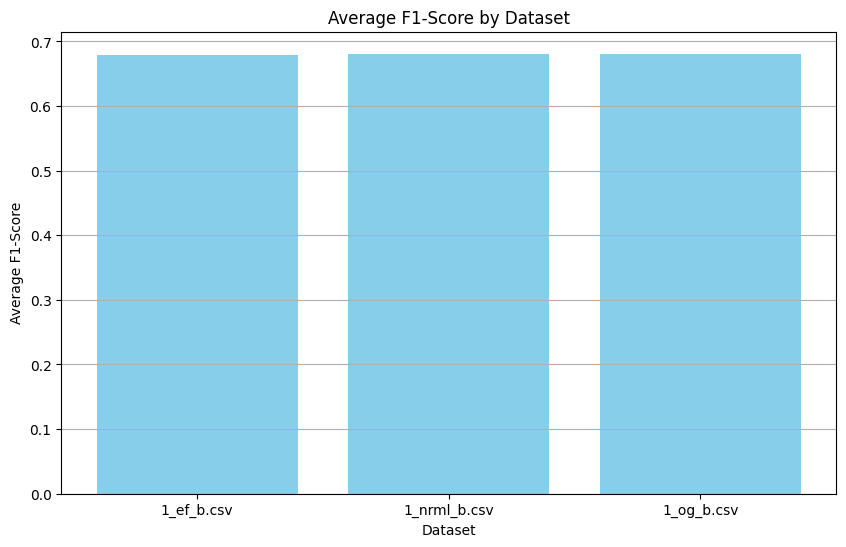


Average F1-Score by Dataset:
     dataset  avg_f1_score
  1_ef_b.csv      0.678925
1_nrml_b.csv      0.680994
  1_og_b.csv      0.681034


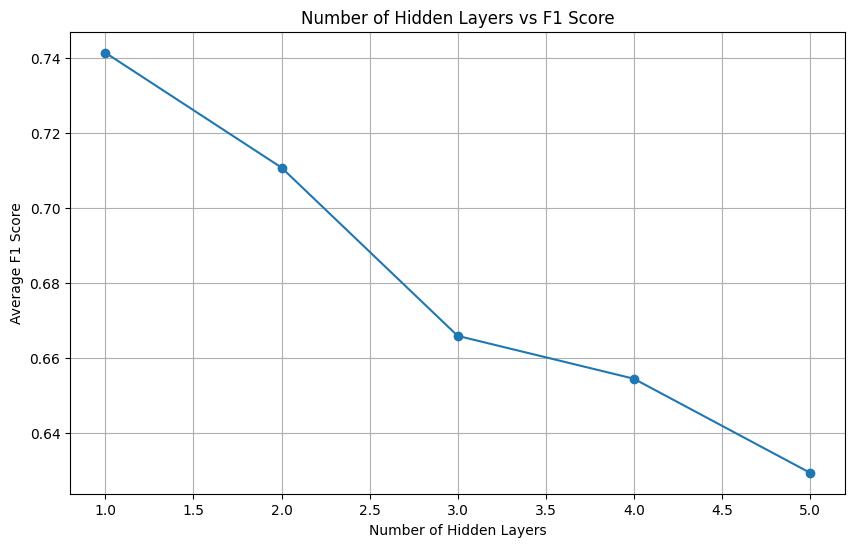


Average F1-Score by Number of Hidden Layers:
 num_hidden_layers  avg_f1_score
                 1      0.741295
                 2      0.710679
                 3      0.665836
                 4      0.654418
                 5      0.629360


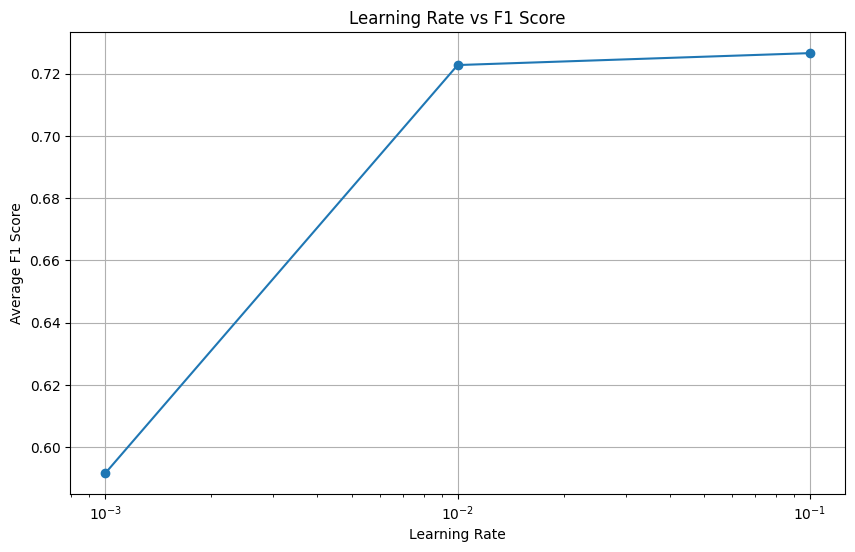


Average F1-Score by Learning Rate:
 learning_rate  avg_f1_score
         0.001      0.591637
         0.010      0.722741
         0.100      0.726574


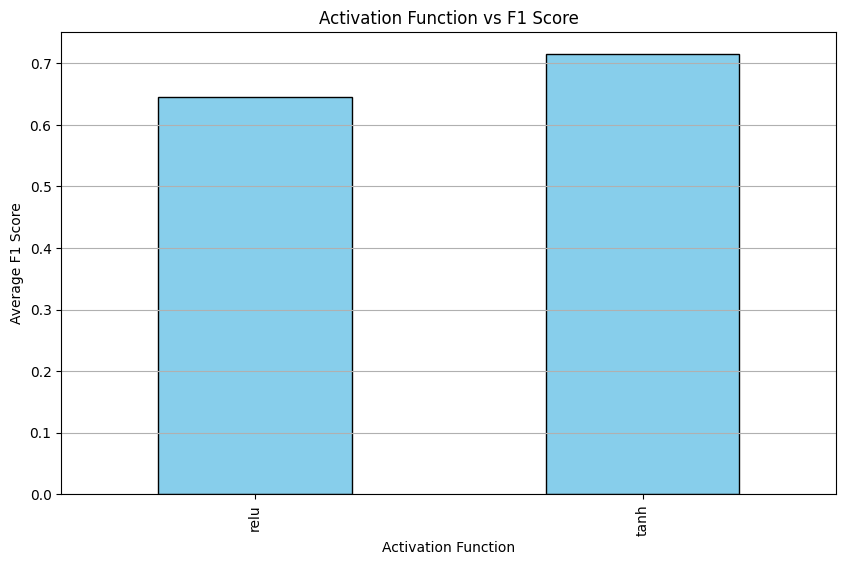


Average F1-Score by Activation Function:
activation  avg_f1_score
      relu      0.645430
      tanh      0.715205


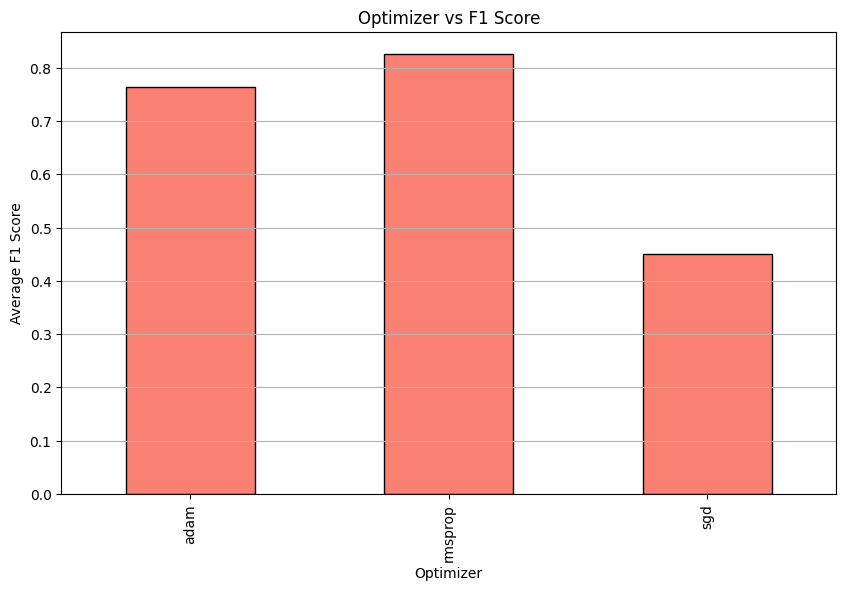


Average F1-Score by Optimizer:
optimizer  avg_f1_score
     adam      0.764747
  rmsprop      0.826114
      sgd      0.450091


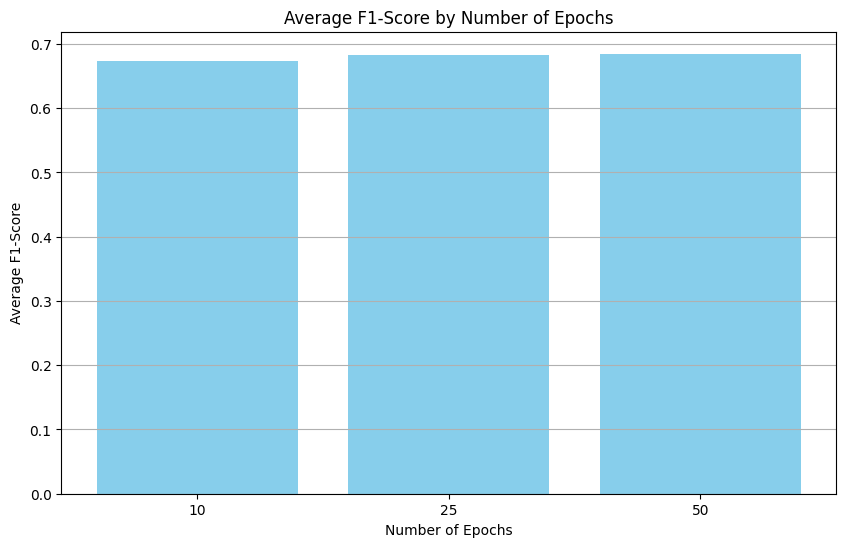


Average F1-Score by Number of Epochs:
 epochs  avg_f1_score
     10      0.673039
     25      0.683184
     50      0.684729


In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `results_df` is your DataFrame containing the results
# Ensure results_df is already defined and populated with your hyperparameter search results



# Analyze the effect of datasets
dataset_analysis = results_df.groupby('dataset')['avg_f1_score'].mean().reset_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(dataset_analysis['dataset'], dataset_analysis['avg_f1_score'], color='skyblue')

plt.title("Average F1-Score by Dataset")
plt.xlabel("Dataset")
plt.ylabel("Average F1-Score")
plt.grid(axis='y')

plt.show()


print("\nAverage F1-Score by Dataset:")
print(dataset_analysis.to_string(index=False))


# Calculate the number of hidden layers for each configuration
results_df['num_hidden_layers'] = results_df['hidden_layers'].apply(len)

# Group by the number of hidden layers and compute the mean F1 score
hidden_layer_f1 = results_df.groupby('num_hidden_layers')['avg_f1_score'].mean()

# Plot: Number of Hidden Layers vs F1 Score
plt.figure(figsize=(10, 6))
plt.plot(hidden_layer_f1.index, hidden_layer_f1.values, marker='o', linestyle='-')
plt.title('Number of Hidden Layers vs F1 Score')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Average F1 Score')
plt.grid(True)
plt.show()


print("\nAverage F1-Score by Number of Hidden Layers:")
print(hidden_layer_f1.reset_index().to_string(index=False))

# Plot: Learning Rate vs F1 Score
learning_rate_f1 = results_df.groupby('learning_rate')['avg_f1_score'].mean()
plt.figure(figsize=(10, 6))
plt.plot(learning_rate_f1.index, learning_rate_f1.values, marker='o', linestyle='-')
plt.title('Learning Rate vs F1 Score')
plt.xlabel('Learning Rate')
plt.ylabel('Average F1 Score')
plt.xscale('log')  # Log scale for learning rate
plt.grid(True)
plt.show()

print("\nAverage F1-Score by Learning Rate:")
print(learning_rate_f1.reset_index().to_string(index=False))


# Plot: Activation Function vs F1 Score
activation_f1 = results_df.groupby('activation')['avg_f1_score'].mean()
plt.figure(figsize=(10, 6))
activation_f1.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Activation Function vs F1 Score')
plt.xlabel('Activation Function')
plt.ylabel('Average F1 Score')
plt.grid(axis='y')
plt.show()


print("\nAverage F1-Score by Activation Function:")
print(activation_f1.reset_index().to_string(index=False))

# Plot: Optimizer vs F1 Score
optimizer_f1 = results_df.groupby('optimizer')['avg_f1_score'].mean()
plt.figure(figsize=(10, 6))
optimizer_f1.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Optimizer vs F1 Score')
plt.xlabel('Optimizer')
plt.ylabel('Average F1 Score')
plt.grid(axis='y')
plt.show()

print("\nAverage F1-Score by Optimizer:")
print(optimizer_f1.reset_index().to_string(index=False))


# Analyze the effect of epochs
epochs_analysis = results_df.groupby('epochs')['avg_f1_score'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(epochs_analysis['epochs'].astype(str), epochs_analysis['avg_f1_score'], color='skyblue')
plt.title("Average F1-Score by Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Average F1-Score")
plt.grid(axis='y')
plt.show()

print("\nAverage F1-Score by Number of Epochs:")
print(epochs_analysis.to_string(index=False))

In [17]:
# Sort by F1-score to identify the best configurations
top_10_configs = results_df.sort_values(by='avg_f1_score', ascending=False).head(10)
print("\nTop 3 Configurations:")
print(top_10_configs)



Top 3 Configurations:
          dataset     hidden_layers  learning_rate activation optimizer  \
403  1_nrml_b.csv      [15, 15, 15]           0.01       relu   rmsprop   
618    1_og_b.csv          [15, 15]           0.01       relu   rmsprop   
619    1_og_b.csv          [15, 15]           0.01       relu   rmsprop   
361  1_nrml_b.csv          [15, 15]           0.10       relu      adam   
620    1_og_b.csv          [15, 15]           0.01       relu   rmsprop   
348  1_nrml_b.csv          [15, 15]           0.01       relu   rmsprop   
349  1_nrml_b.csv          [15, 15]           0.01       relu   rmsprop   
685    1_og_b.csv      [15, 15, 15]           0.10       relu      adam   
740    1_og_b.csv  [15, 15, 15, 15]           0.10       relu      adam   
593    1_og_b.csv              [15]           0.10       tanh   rmsprop   

     epochs  avg_f1_score  num_hidden_layers  
403      25      0.953366                  3  
618      10      0.951008                  2  
619      2